In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import os
from tqdm import trange, tqdm
import cloud_correction as cc
from scipy.interpolate import interp1d
#from adjust183 import adjust183
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import skew
plt.rcParams.update({'font.size': 16})

In [2]:
y = xarray.open_dataset(os.path.expanduser('~/Projects/git/aws/Validation/TB_AWS_m60_p60.nc'))
TB0 = y.TB
cases = TB0.cases.values.size

#IS = xarray.open_dataset(os.path.expanduser('~/Projects/git/aws/Validation/isurface.nc'))
#isurface = IS.i_surface         

In [3]:
A = xarray.open_dataset('/home/inderpreet/Projects/git/aws/Validation/TB_AWS_m60_p60_noise.nc')
TB = A.TB_noise
TB
channels= TB.channels.values
channel_names = [channels[i].replace('C', 'AWS-') for i in range(len(channels))]
channels
channel_names

['AWS-21',
 'AWS-31',
 'AWS-32',
 'AWS-33',
 'AWS-34',
 'AWS-35',
 'AWS-36',
 'AWS-4X',
 'AWS-41',
 'AWS-42',
 'AWS-43']

In [4]:
ias = 1
ics = 0

c183 = 'C35'
c325 = 'C43'
c229 = 'C32'

cs_reject    = 0.5
if c325 == 'C4X':
    dTb_max_fit  = 20
else:
    dTb_max_fit  = 40
    
dTb_max_meas = 15
#dTb_max_meas = 25

cs_frac_removed229 = 0.41
noisy_fit    = False
binstep      = 0.2
#thin data
thin = True
npoly = 3
reject = True
# use all data without thinning


5 10 2


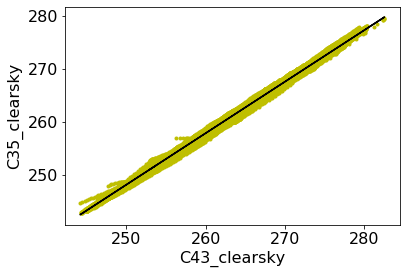

In [5]:
i183 = cc.get_index(c183, channels)
i325 = cc.get_index(c325, channels)
i229 = cc.get_index(c229, channels)

print(i183, i325, i229)

clearskyfit = cc.get_clearsky_fit(i183, i325, TB0, ics, channels)
#plt.savefig('Figures/%s_%s_scatter.png'%(c183, c325), bbox_inches='tight')

In [6]:
cases = TB.shape[2]

### reject fraction of clearsky [thinning of datasets]

In [7]:
np.random.seed(4)
random_cases = np.random.rand(cases)
if thin:
    ireje = (abs(TB0[i183, ias, :] - TB0[i183, ics, :]) < 0.2) & (random_cases < cs_reject)
    ntot = cases - np.sum(ireje).values

    ireje_229 = (abs(TB0[i229, ias, :] - TB0[i229, ics, :]) < 0.2) & (random_cases < cs_reject)
    ntot_229 = cases - np.sum(ireje_229).values

else:
    ntot = cases
    ntot_229 = cases  
print(ntot, ntot_229)  


69670 74540


In [8]:
np.where(ireje)

(array([     5,      7,      9, ..., 125455, 125456, 125459]),)

### mimic Sreerekha et al with 6K threshold

In [9]:
if thin:
    ic229 = np.where((abs(TB[i229, ias, ~ireje_229] - TB0[i229,ics, ~ireje_229]) <= 6.)) [0]
    TB229 = TB[i229, ias, ~ireje_229][ic229]
else:
    ic229 = np.where((abs(TB[i229, ias, :] - TB0[i229,ics, :]) <= 6.)) [0]
    TB229 = TB[i229, ias, :][ic229]

In [10]:
TB229

<xarray.DataArray 'TB_noise' (cases: 69021)>
array([237.330583, 237.621447, 237.55301 , ..., 272.436107, 272.084732,
       271.232344])
Coordinates:
    channels  <U3 'C32'
    sky       <U6 'allsky'
  * cases     (cases) int64 0 1 2 3 4 6 ... 125449 125451 125453 125457 125458

### select measurement data

In [11]:
tb183 = TB[i183, ias, :]
tb325 = TB[i325, ias, :]

if thin:
    im = np.where((abs(tb183 - tb325) <= dTb_max_meas) & (~ireje))[0]
else:
    im = np.where((abs(tb183 - tb325) <= dTb_max_meas))[0]

tb183 = tb183[im]
tb325 = tb325[im]
tb183_sim = TB[i183, ias, :]
print(tb183.size/ntot)
print(TB[i183, ias, ~ireje].size, TB[i183, ias, :].size, im.size)

0.9715659537821157
69670 125460 67689


### find the index for the data to be used in the fits

In [12]:
ifit = np.where(np.abs(TB0[i325, ias, :] - TB0[i183, ias, :]) <= dTb_max_fit)[0]
#ifit = np.where(np.abs(TB0[i325, ias, ~ireje] - TB0[i183, ias, ~ireje]) <= dTb_max_fit)[0]

In [13]:
def adjust183(tb183_cs_sim, tb183_as_sim, tb325_as_sim, tb183, tb325, tb183_sim, noise183, thin, npoly):

# Variables for fitting
    x = tb325_as_sim - tb183_as_sim
    y = tb183_cs_sim - tb183_as_sim

# Select subset to consider as cloudy for fitting and perform fit

    dtb_fit = 0.2
#    npoly   = 3

    cloudy0 = abs( y ) > 0.2

    
    p = np.polyfit(x[cloudy0], y[cloudy0], npoly)
    print (p)

# Init tb_cs_est

    tb_cs_est = tb183.copy()

    
# Create boolean for cases considered as cloudy and shall be adjusted
# We do this by finding cases where adjustment is > 2 std of noise
# (Tested and 1 std gives quite similar results, except for Ch32)

#    xtest      = np.arange(-10, 20, 0.2)
    xtest      = np.arange(-10, 3, 0.2)
    f          = interp1d( np.polyval(p, xtest), xtest)
    dtb        = f(noise183)
    print('dtb', dtb)
    x_measured = tb325 - tb183
    cloudy     = x_measured < dtb
    
    print ('% of simulations corrected: ', (tb183[cloudy].size*100)/x_measured.size )

#Apply adjustment

    tb_cs_est[cloudy] = tb183[cloudy] + np.polyval( p, x_measured[cloudy])
    tb_cs_rej = tb183[~cloudy]
         
    

    return tb_cs_est, tb_cs_rej

In [14]:
def plot_scatter(tb183_cs_sim, tb183_as_sim, tb325_as_sim, i183, i325, channels, npoly):
    x = tb325_as_sim - tb183_as_sim
    y = tb183_cs_sim - tb183_as_sim

# Select subset to consider as cloudy for fitting and perform fit

    dtb_fit = 0.2
#    npoly   = 3

    cloudy0 = abs( y ) > 0.2

    p = np.polyfit(x[cloudy0], y[cloudy0], npoly)
    
    xsort = np.sort(x[cloudy0])
    fig, ax = plt.subplots(1, 1, figsize = [8,8])
    ax.plot(x[cloudy0],y[cloudy0], 'g.')
    ax.plot(x[~cloudy0], y[~cloudy0], 'r.' )
    ax.plot(xsort, np.polyval(p, xsort), 'k')
    
    xpositive = np.arange(-10, 5, 0.1)
    ax.plot(xpositive, np.polyval(p, xpositive), 'k')
    
    y0 = 1.

    
    f = interp1d( np.polyval(p, xsort), xsort)
    dtb = f(y0)
    
    cloudy = x < dtb
    print(np.sum(cloudy), np.sum(~cloudy), x.size, np.sum(cloudy)/x.size)
    
    ax.axvline(x = dtb, ls = '--')
    ax.set_xlabel('TB %s allsky - TB %s allsky [K]'%(channels[i325], channels[i183]))
    ax.set_ylabel('TB %s clearsky - TB %s allsky [K]'%(channels[i183], channels[i183]))
    
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(which = 'both', alpha = 0.4)
    
    fig.savefig('Figures/fit_%s_%s.png'%(channels[i183], channels[i325]), bbox_inches='tight')

<xarray.DataArray 'TB' ()>
array(6072)
Coordinates:
    sky      <U6 'allsky' <xarray.DataArray 'TB' ()>
array(118957)
Coordinates:
    sky      <U6 'allsky' 125029 <xarray.DataArray 'TB' ()>
array(0.04856473)
Coordinates:
    sky      <U6 'allsky'


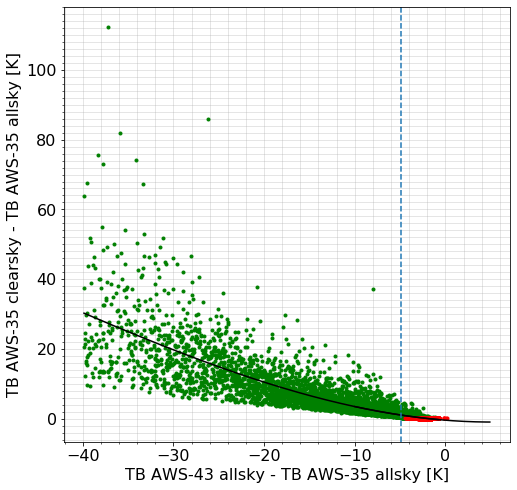

In [15]:
npoly = 3
plot_scatter(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], i183, i325, channel_names, npoly)
#plot_scatter(TB0[i183, ics, ~ireje][ifit], TB0[i183, ias, ~ireje][ifit], 
#                          TB0[i325, ias, ~ireje][ifit], i183, i325, channel_names, npoly)

In [16]:
std = np.std(TB[i183, ics, :]-TB0[i183, ics, :])


if thin:    
    npoly = 3
    noise183 = 2.0*std
    tb_cs_pre, tb_cs_rej = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)
    noise183 = 1.0*std
    tb_cs_pre_1std, tb_cs_rej_1std = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)

else:
    npoly = 3
    noise183 = 2.0*std
    tb_cs_pre, tb_cs_rej = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)
    noise183 = 1.0*std
    tb_cs_pre_1std, tb_cs_rej_1std = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)



[ 1.41614472e-04  1.97483595e-02 -2.07628257e-01 -4.53735521e-01]
dtb -5.486473857245445
% of simulations corrected:  6.396903485056656
[ 1.41614472e-04  1.97483595e-02 -2.07628257e-01 -4.53735521e-01]
dtb -3.8441338973258468
% of simulations corrected:  18.99717827121098


#### values to mimic Sreerekha etal

In [17]:
if thin :
    rej3a = (1 - tb_cs_pre.size/ntot)*100
    rej3b = (1 - tb_cs_pre_1std.size/ntot)*100
    #rej4  = (1 - cs_frac_removed229*TB229.size/ntot_229) * 100
    rej4 = (1 - ((1 - cs_frac_removed229)*TB229.size)/ntot_229)*100
    rej5  = (1 - tb_cs_rej_1std.size/ntot)*100



    print( rej3a, rej3b, rej4, rej5)

2.8434046217884257 2.8434046217884257 45.368406224845714 21.30041624802641


#### calculate PDFs

In [18]:
bins = np.arange(-20, 5, binstep)

In [19]:
if thin:
    hist1  = np.histogram(TB[i183, ics, ~ireje] - TB0[i183, ics, ~ireje], bins, density = True)
    hist2a = np.histogram(TB[i183, ias, ~ireje] - TB0[i183, ics, ~ireje], bins, density = True)
    hist2b = np.histogram(TB[i183, ias, im] - TB0[i183, ics, im], bins, density = True)
    hist3a  = np.histogram(tb_cs_pre - TB0[i183, ics, im], bins, density = True)
    hist3b  = np.histogram(tb_cs_pre_1std - TB0[i183, ics, im], bins, density = True)
    hist4  = np.histogram(TB[i183, ias, ~ireje_229][ic229] - TB0[i183, ics, ~ireje_229][ic229], bins, density = True)
    hist5 = np.histogram(tb_cs_rej - TB0[i183, ics, im], bins, density = True)
    
else:
    hist1  = np.histogram(TB[i183, ics, :] - TB0[i183, ics, :], bins, density = True)
    hist2a = np.histogram(TB[i183, ias, :] - TB0[i183, ics, :], bins, density = True)
    hist2b = np.histogram(TB[i183, ias, im] - TB0[i183, ics, im], bins, density = True)
    hist3a  = np.histogram(tb_cs_pre - TB0[i183, ics, im], bins, density = True)
    hist3b  = np.histogram(tb_cs_pre_1std - TB0[i183, ics, im], bins, density = True)
    hist4  = np.histogram(TB[i183, ias, :][ic229] - TB0[i183, ics, :][ic229], bins, density = True)
    hist5 = np.histogram(tb_cs_rej - TB0[i183, ics, im], bins, density = True)
    

#### plot deviations

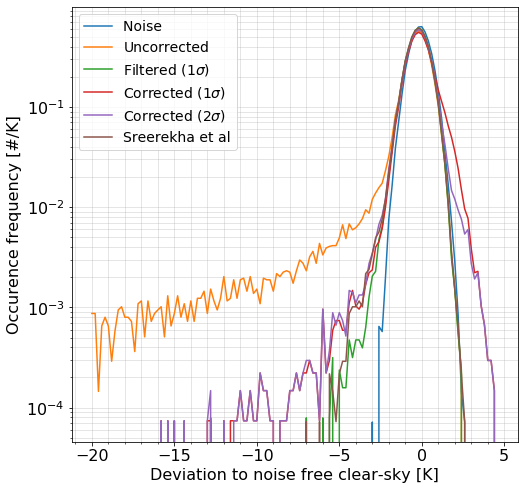

In [27]:
fig, ax = plt.subplots(1,1, figsize = [8,8])


    
ax.plot(bins[:-1], hist1[0])
ax.plot(bins[:-1], hist2a[0])
ax.plot(bins[:-1], hist5[0])
ax.plot(bins[:-1], hist3b[0])
ax.plot(bins[:-1], hist3a[0])
ax.plot(bins[:-1], hist4[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')

if thin:
    ax.legend(['Noise ', 'Uncorrected', 'Filtered (1$\sigma$)', 'Corrected (1$\sigma$)',  'Corrected (2$\sigma$)',
          'Sreerekha et al', ], prop={'size': 14} )
else:
    ax.legend(['Noise ', 'Uncorrected', 'Filtered (1$\sigma$)', 'Corrected (1$\sigma$)',
          'Sreerekha et al', ], prop={'size': 14} )
    
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)

if thin:
    fig.savefig('Figures/PDF_corrected_%s_%s_thinned.png'%(channel_names[i183], channel_names[i325]))
else:
    fig.savefig('Figures/PDF_corrected_%s_%s_all.png'%(channel_names[i183], channel_names[i325]))

#### calculate bias

In [21]:
b1  = np.mean(TB[i183, ics, ~ireje] - TB0[i183, ics, ~ireje]).values
b2a = np.mean(TB[i183, ias,~ireje] - TB0[i183, ics, ~ireje]).values
b2b = np.mean(TB[i183, ias, im] - TB0[i183, ics, im]).values
b3a  = np.mean(tb_cs_pre - TB0[i183, ics, im]).values
b3b  = np.mean(tb_cs_pre_1std - TB0[i183, ics, im]).values

b5  = np.mean(tb_cs_rej - TB0[i183, ics, im]).values

if thin:
    b4  = np.mean(TB[i183, ias, ~ireje_229][ic229] - TB0[i183, ics, ~ireje_229][ic229]).values
else:
    b4  = np.mean(TB[i183, ias, :][ic229] - TB0[i183, ics, :][ic229]).values

#### calculate MAE

In [22]:
mae1  = np.mean(abs(TB[i183, ics, ~ireje] - TB0[i183, ics, ~ireje])).values
mae2a = np.mean(abs(TB[i183, ias, ~ireje] - TB0[i183, ics, ~ireje])).values
mae2b = np.mean(abs(TB[i183, ias, im] - TB0[i183, ics, im])).values
mae3a  = np.mean(abs(tb_cs_pre - TB0[i183, ics, im])).values
mae3b  = np.mean(abs(tb_cs_pre_1std - TB0[i183, ics, im])).values
mae5  = np.mean(abs(tb_cs_rej - TB0[i183, ics, im])).values

if thin:
    mae4  = np.mean(abs(TB[i183, ias, ~ireje_229][ic229] - TB0[i183, ics, ~ireje_229][ic229])).values
else:
    mae4  = np.mean(abs(TB[i183, ias, :][ic229] - TB0[i183, ics, :][ic229])).values

#### calculate std

In [23]:
std1  = np.std(TB[i183, ics, ~ireje] - TB0[i183, ics, ~ireje]).values
std2a = np.std(TB[i183, ias, ~ireje] - TB0[i183, ics, ~ireje]).values
std2b = np.std(TB[i183, ias, im] - TB0[i183, ics, im]).values
std3a  = np.std(tb_cs_pre - TB0[i183, ics, im]).values
std3b  = np.std(tb_cs_pre_1std - TB0[i183, ics, im]).values
std5  = np.std(tb_cs_rej - TB0[i183, ics, im]).values

if thin:
    std4  = np.std(TB[i183, ias, ~ireje_229][ic229] - TB0[i183, ics, ~ireje_229][ic229]).values
else:
    std4  = np.std(TB[i183, ias, :][ic229] - TB0[i183, ics, :][ic229]).values

#### calculate standard measure of skewness

In [24]:
sk1  = skew(TB[i183, ics, ~ireje] - TB0[i183, ics, ~ireje])
sk2a = skew(TB[i183, ias, ~ireje] - TB0[i183, ics, ~ireje])
sk2b = skew(TB[i183, ias, im] - TB0[i183, ics, im])
sk3a  = skew(tb_cs_pre - TB0[i183, ics, im])
sk3b  = skew(tb_cs_pre_1std - TB0[i183, ics, im])
sk5  = skew(tb_cs_rej- TB0[i183, ics, im])

if thin:
    sk4  = skew(TB[i183, ias, ~ireje_229][ic229] - TB0[i183, ics, ~ireje_229][ic229])
else:
    sk4  = skew(TB[i183, ias, :][ic229] - TB0[i183, ics, :][ic229])

In [25]:
from tabulate import tabulate
rej1 = 0
rej2a = 0
b = [b1,  b2a, b3a, b3b, b4, b5]
std = [std1,  std2a, std3a, std3b, std4, std5]
mae = [mae1,  mae2a, mae3a, mae3b, mae4, mae5]
skewness = [sk1,  sk2a, sk3a, sk3b, sk4, sk5]
rejected = [rej1, rej2a, rej3a, rej3b, rej4, rej5]
sets = ['Noise', 'uncorrected', 'corrected(2sigma)', 'corrected(1sigma)', 'sreerekha et al', 'filtered(1sigma)']

table  = [[sets[i], b[i], std[i], skewness[i], rejected[i]] for i in range(6)]

print(tabulate(table
         , ["Dataset","bias", "std", "measure skewness", "fraction rejected"],  tablefmt="latex", floatfmt=".2f"))


\begin{tabular}{lrrrr}
\hline
 Dataset           &   bias &   std &   measure skewness &   fraction rejected \\
\hline
 Noise             &   0.00 &  0.63 &               0.01 &                0.00 \\
 uncorrected       &  -0.83 &  4.51 &             -10.85 &                0.00 \\
 corrected(2sigma) &  -0.10 &  0.84 &              -2.42 &                2.84 \\
 corrected(1sigma) &   0.01 &  0.91 &              -1.71 &                2.84 \\
 sreerekha et al   &  -0.13 &  0.69 &              -0.52 &               45.37 \\
 filtered(1sigma)  &  -0.13 &  0.68 &              -0.47 &               21.30 \\
\hline
\end{tabular}
